# Creating Parcel Graphics for Memo

This was originally done in the Python Notebook "Parcel_Analysis" but after I figured out using the LandVision data that LA county parcels needed to be consolidated to show the true ownership status, I am separating these graphics out to make it simpler.

In [1]:
import osmnx as ox
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)

import pandas as pd, numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas

import matplotlib.pyplot as plt

## Load in parcel information, and consolidate LA parcels

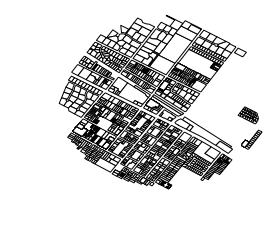

In [2]:
fruit_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/fruit_res.shp')
mp_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/mp_res.shp')
soto_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/soto_res.shp')
sl_pz = geopandas.read_file('GIS/Parcel_Zoning/Subset/sl_res.shp')

f, ax = plt.subplots(1, figsize=(4, 4))
ax = mp_pz.plot(ax = ax, color='white', edgecolor='black', linewidth=1)
ax.set_axis_off()
plt.show()

Subset Silver Lake to within 402.336 meters of the station, which is a quarter mile of the station

In [3]:
sl_pz = sl_pz[sl_pz['dist_stati'] <= 402.336]

This is the code to consolidate the LA parcels into the master parcels by ownership

In [4]:
soto_pz2 = soto_pz[['assetid', 'bpp', 'id','lot','shape_area','zone_cmplt','zone_base','dist_stati','parcel_are','geometry']]
sl_pz2 = sl_pz[['assetid', 'bpp', 'id','lot','shape_area','zone_cmplt','zone_base','dist_stati','parcel_are','geometry']]

soto_pz2.head(3)

,assetid,bpp,id,lot,shape_area,zone_cmplt,zone_base,dist_stati,parcel_are,geometry
0,1475921.0,5175027003,331.0,23,5433.818538,R2-1-CUGU,Multi-Family Residential,798.989183,5455.762698,POLYGON ((-118.2104603343075 34.05096083937416...
1,1475938.0,5175017010,332.0,10,5495.704778,R2-1-CUGU,Multi-Family Residential,799.633580,5517.906385,"POLYGON ((-118.2094280859165 34.0507960205358,..."
2,1476094.0,5175027019,336.0,38,5187.663818,R2-1-CUGU,Multi-Family Residential,795.926899,5208.608658,POLYGON ((-118.2105268789543 34.05085647001695...


In [5]:
soto_pz_agg = soto_pz2.dissolve(by='bpp', aggfunc='sum')
sl_pz_agg = sl_pz2.dissolve(by='bpp', aggfunc='sum')

soto_pz_agg['bpp'] = soto_pz_agg.index
sl_pz_agg['bpp'] = sl_pz_agg.index

sl_pz_agg.head(2)

,geometry,assetid,id,shape_area,dist_stati,parcel_are,bpp
bpp,,,,,,,
5420005001,POLYGON ((-118.2548220158466 34.09115749236824...,1361413.0,361.0,3664.845801,278.807241,3679.361451,5420005001
5420005002,POLYGON ((-118.2548220158466 34.09115749236824...,1361672.0,366.0,2748.873929,287.895697,2759.762397,5420005002


In [6]:
print('Boyle Heights')
print(len(soto_pz))
print(len(soto_pz_agg))
print ('Silver Lake')
print(len(sl_pz))
print(len(sl_pz_agg))

Boyle Heights
2355
1857
Silver Lake
733
580


### Input station coordinates and buffers for plotting

In [7]:
fruit_station = geopandas.GeoSeries([Point([(-122.224175, 37.774836)])])
mp_station = geopandas.GeoSeries([Point([(-122.182405, 37.454745)])])
soto_station = geopandas.GeoSeries([Point([(-118.210061, 34.0437469999999)])])
sl_station = geopandas.GeoSeries([Point([(-118.25518, 34.093765)])])

fruit_station = geopandas.GeoDataFrame({'geometry': fruit_station, 'fruit_station':['fruitvale']})
mp_station = geopandas.GeoDataFrame({'geometry': mp_station, 'mp_station':['menlo']})
soto_station = geopandas.GeoDataFrame({'geometry': soto_station, 'soto_station':['soto']})
sl_station = geopandas.GeoDataFrame({'geometry': sl_station, 'sl_station':['silver lake']})

sl_station

,geometry,sl_station
0,POINT (-118.25518 34.093765),silver lake


In [8]:
print(fruit_station.crs)

fruit_station.crs = {'init': 'epsg:4269'}
mp_station.crs = {'init': 'epsg:4269'}
soto_station.crs = {'init': 'epsg:4269'}
sl_station.crs = {'init': 'epsg:4269'}
 
print(fruit_station.crs)

None
{'init': 'epsg:4269'}


In [9]:
station_quarter = geopandas.read_file('case_studies/buffers/station_quarter.shp')
station_half = geopandas.read_file('case_studies/buffers/station_half.shp')

station_quarter

,key,name,lat,lon,geometry
0,Bay Area Rapid TransitFTVL,Fruitvale BART,37.774836,-122.224175,POLYGON ((-122.2196068707346 37.77480583407194...
1,Caltrain70162,Menlo Park Caltrain,37.454745,-122.182405,"POLYGON ((-122.1778564564413 37.4547134431177,..."
2,Metro - Los Angeles80405,Soto Station,34.043747,-118.210061,POLYGON ((-118.2057173735685 34.04357729743138...
3,Metro - Los Angeles80209,Wilshire / Vermont Station,34.062701,-118.290082,POLYGON ((-118.2857369006203 34.06253404360918...
4,Metro - Los Angeles89,Allesandro / Oak Glen,34.093765,-118.255180,POLYGON ((-118.2508335337178 34.09359667575826...


## Create histograms, etc.

In [14]:
small_fruit_res = fruit_pz[fruit_pz['parcel_are']<20000]
small_mp_res = mp_pz[mp_pz['parcel_are']<20000]
small_soto_res = soto_pz_agg[soto_pz_agg['parcel_are']<20000]
small_sl_res = sl_pz_agg[sl_pz_agg['parcel_are']<20000]

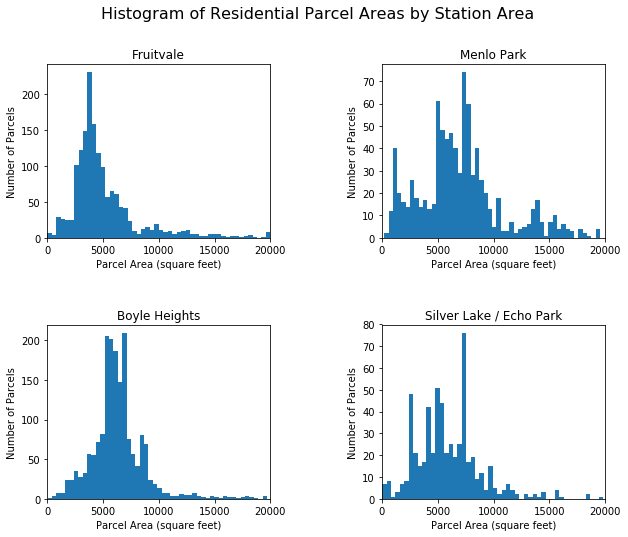

In [15]:
plt.figure(1, figsize=(10,8), )
plt.suptitle("Histogram of Residential Parcel Areas by Station Area", fontsize=16)

ax = plt.subplot(221)
ax.set_title("Fruitvale")
ax.set_xlabel('Parcel Area (square feet)', fontsize=10)
ax.set_ylabel('Number of Parcels', fontsize=10)
ax.set_xlim(0,20000)
ax.hist(small_fruit_res['parcel_are'], bins=50)

ax = plt.subplot(222)
ax.set_title("Menlo Park")
ax.set_xlabel('Parcel Area (square feet)', fontsize=10)
ax.set_ylabel('Number of Parcels', fontsize=10)
ax.set_xlim(0,20000)
ax.hist(small_mp_res.drop_duplicates('PARCEL_ID')['parcel_are'], bins=50)

ax = plt.subplot(223)
ax.set_title("Boyle Heights")
ax.set_xlabel('Parcel Area (square feet)', fontsize=10)
ax.set_ylabel('Number of Parcels', fontsize=10)
ax.set_xlim(0,20000)
ax.hist(small_soto_res['parcel_are'], bins=50)

#ax = plt.subplot(323)
#ax.set_title("Wilshire / Vermont Station")
#ax.set_xlabel('Parcel Area (square feet)', fontsize=10)
#ax.set_ylabel('Number of Parcels', fontsize=10)
#ax.set_xlim(0,20000)
#ax.hist(small_wv_res['parcel_area'], bins=50)

ax = plt.subplot(224)
ax.set_title("Silver Lake / Echo Park")
ax.set_xlabel('Parcel Area (square feet)', fontsize=10)
ax.set_ylabel('Number of Parcels', fontsize=10)
ax.set_xlim(0,20000)
ax.hist(small_sl_res['parcel_are'], bins=50)

plt.subplots_adjust(wspace=.5, hspace=.5)
plt.savefig('parcel_area_hist.png')
plt.show()

In [16]:
mp_pz2 = mp_pz.drop_duplicates('PARCEL_ID')

fruit_pz['Parcel_Bucket'] = 'N/A'
mp_pz2['Parcel_Bucket'] = 'N/A'
soto_pz_agg['Parcel_Bucket'] = 'N/A'
sl_pz_agg['Parcel_Bucket'] = 'N/A'

C:\Users\jared\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
fruit_pz.loc[(fruit_pz['parcel_are'] < 5000),'Parcel_Bucket'] = 'Less than 5,000'
fruit_pz.loc[((fruit_pz['parcel_are'] >= 5000) & (fruit_pz['parcel_are'] < 10000)),
              'Parcel_Bucket'] = '5,000 to 9,999'
fruit_pz.loc[((fruit_pz['parcel_are'] >= 10000) & (fruit_pz['parcel_are'] < 20000)),
              'Parcel_Bucket'] = '10,000 to 19,999'
fruit_pz.loc[(fruit_pz['parcel_are'] >= 20000),'Parcel_Bucket'] = 'Greater than 20,000'

fruit_pz.head()

,index,apn,apn_sort,book,centroid_x,centroid_y,clca_categ,comments,date_creat,date_updat,...,BASEZONE,OVERLAY,ZNLABEL,zone_base,dist_stati,parcel_are,parcel_len,parcel_quo,geometry,Parcel_Bucket
0,5,33-2127-11,033 212701100,33,6.064269e+06,2.111500e+06,None,None,2004-06-07,2004-06-07,...,RM-3,None,RM-3,Multi-Family Residential,756.169981,3804.304088,303.358662,0.519485,POLYGON ((-122.2209985275363 37.78121209779937...,"Less than 5,000"
1,6,33-2136-27-1,033 213602701,33,6.065076e+06,2.110309e+06,None,None,2004-06-07,2004-06-07,...,RM-2,None,RM-2,Multi-Family Residential,622.041286,5958.258968,345.136906,0.628561,POLYGON ((-122.2181174853883 37.77796759230895...,"5,000 to 9,999"
2,8,25-722-16,025 072201600,25,6.063121e+06,2.111167e+06,None,None,2004-06-07,2004-06-07,...,RM-2,None,RM-2,Multi-Family Residential,607.809772,6653.322477,400.889705,0.520235,POLYGON ((-122.2249961267633 37.78043837887684...,"5,000 to 9,999"
3,9,33-2143-3,033 214300300,33,6.065652e+06,2.109656e+06,None,None,2004-06-07,2004-06-07,...,RM-2,None,RM-2,Multi-Family Residential,709.800085,3997.884362,279.925519,0.641145,"POLYGON ((-122.2161270267888 37.7762128014041,...","Less than 5,000"
4,10,33-2127-3,033 212700300,33,6.064577e+06,2.111481e+06,None,None,2004-06-07,2004-06-07,...,RM-2,None,RM-2,Multi-Family Residential,789.690527,4497.171299,315.203238,0.568812,POLYGON ((-122.2199239139756 37.78117969107637...,"Less than 5,000"


In [18]:
mp_pz2.loc[(mp_pz2['parcel_are'] < 5000),'Parcel_Bucket'] = 'Less than 5,000'
mp_pz2.loc[((mp_pz2['parcel_are'] >= 5000) & (mp_pz2['parcel_are'] < 10000)),
              'Parcel_Bucket'] = '5,000 to 9,999'
mp_pz2.loc[((mp_pz2['parcel_are'] >= 10000) & (mp_pz2['parcel_are'] < 20000)),
              'Parcel_Bucket'] = '10,000 to 19,999'
mp_pz2.loc[(mp_pz2['parcel_are'] >= 20000),'Parcel_Bucket'] = 'Greater than 20,000'

C:\Users\jared\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
soto_pz_agg.loc[(soto_pz_agg['parcel_are'] < 5000),'Parcel_Bucket'] = 'Less than 5,000'
soto_pz_agg.loc[((soto_pz_agg['parcel_are'] >= 5000) & (soto_pz_agg['parcel_are'] < 10000)),
              'Parcel_Bucket'] = '5,000 to 9,999'
soto_pz_agg.loc[((soto_pz_agg['parcel_are'] >= 10000) & (soto_pz_agg['parcel_are'] < 20000)),
              'Parcel_Bucket'] = '10,000 to 19,999'
soto_pz_agg.loc[(soto_pz_agg['parcel_are'] >= 20000),'Parcel_Bucket'] = 'Greater than 20,000'

In [20]:
sl_pz_agg.loc[(sl_pz_agg['parcel_are'] < 5000),'Parcel_Bucket'] = 'Less than 5,000'
sl_pz_agg.loc[((sl_pz_agg['parcel_are'] >= 5000) & (sl_pz_agg['parcel_are'] < 10000)),
              'Parcel_Bucket'] = '5,000 to 9,999'
sl_pz_agg.loc[((sl_pz_agg['parcel_are'] >= 10000) & (sl_pz_agg['parcel_are'] < 20000)),
              'Parcel_Bucket'] = '10,000 to 19,999'
sl_pz_agg.loc[(sl_pz_agg['parcel_are'] >= 20000),'Parcel_Bucket'] = 'Greater than 20,000'


In [21]:
fruit_group1 = pd.DataFrame(fruit_pz['parcel_are'].groupby(fruit_pz['Parcel_Bucket']).sum())
mp_group1 = pd.DataFrame(mp_pz2['parcel_are'].groupby(mp_pz2['Parcel_Bucket']).sum())
soto_group1 = pd.DataFrame(soto_pz_agg['parcel_are'].groupby(soto_pz_agg['Parcel_Bucket']).sum())
sl_group1 = pd.DataFrame(sl_pz_agg['parcel_are'].groupby(sl_pz_agg['Parcel_Bucket']).sum())

fruit_group1.rename(columns={'parcel_are':'Fruitvale SF'}, inplace=True)
mp_group1.rename(columns={'parcel_are':'Menlo Park SF'}, inplace=True)
soto_group1.rename(columns={'parcel_are':'Boyle Heights SF'}, inplace=True)
sl_group1.rename(columns={'parcel_are':'Silver Lake SF'}, inplace=True)

parcel_group1 = pd.merge(pd.merge(pd.merge(fruit_group1,mp_group1,how='outer',on='Parcel_Bucket'),
                                  soto_group1,how='outer',on='Parcel_Bucket'), 
                         sl_group1,how='outer',on='Parcel_Bucket')

parcel_group1

,Fruitvale SF,Menlo Park SF,Boyle Heights SF,Silver Lake SF
Parcel_Bucket,,,,
"10,000 to 19,999",1.624742e+06,1.835097e+06,1.155057e+06,5.142603e+05
"5,000 to 9,999",2.647742e+06,3.599199e+06,9.007353e+06,2.141063e+06
"Greater than 20,000",4.579087e+06,7.466452e+06,9.538319e+05,1.149296e+05
"Less than 5,000",3.738033e+06,6.605789e+05,1.407210e+06,7.667865e+05


In [22]:
fruit_group2 = pd.DataFrame(fruit_pz['Parcel_Bucket'].groupby(fruit_pz['Parcel_Bucket']).count())
mp_group2 = pd.DataFrame(mp_pz2['Parcel_Bucket'].groupby(mp_pz2['Parcel_Bucket']).count())
soto_group2 = pd.DataFrame(soto_pz_agg['Parcel_Bucket'].groupby(soto_pz_agg['Parcel_Bucket']).count())
sl_group2 = pd.DataFrame(sl_pz_agg['Parcel_Bucket'].groupby(sl_pz_agg['Parcel_Bucket']).count())

fruit_group2.rename(columns={'Parcel_Bucket':'Fruitvale #'}, inplace=True)
mp_group2.rename(columns={'Parcel_Bucket':'Menlo Park #'}, inplace=True)
soto_group2.rename(columns={'Parcel_Bucket':'Boyle Heights #'}, inplace=True)
sl_group2.rename(columns={'Parcel_Bucket':'Silver Lake #'}, inplace=True)

parcel_group2 = pd.merge(pd.merge(pd.merge(fruit_group2,mp_group2,how='outer',on='Parcel_Bucket'),
                                  soto_group2,how='outer',on='Parcel_Bucket'), 
                         sl_group2,how='outer',on='Parcel_Bucket')

parcel_group2

,Fruitvale #,Menlo Park #,Boyle Heights #,Silver Lake #
Parcel_Bucket,,,,
"10,000 to 19,999",120,132,87,40
"5,000 to 9,999",398,506,1348,307
"Greater than 20,000",67,148,27,4
"Less than 5,000",1062,235,395,229


In [23]:
parcel_breakdown = pd.merge(parcel_group1,parcel_group2,how='outer',on='Parcel_Bucket')

parcel_breakdown

,Fruitvale SF,Menlo Park SF,Boyle Heights SF,Silver Lake SF,Fruitvale #,Menlo Park #,Boyle Heights #,Silver Lake #
Parcel_Bucket,,,,,,,,
"10,000 to 19,999",1.624742e+06,1.835097e+06,1.155057e+06,5.142603e+05,120,132,87,40
"5,000 to 9,999",2.647742e+06,3.599199e+06,9.007353e+06,2.141063e+06,398,506,1348,307
"Greater than 20,000",4.579087e+06,7.466452e+06,9.538319e+05,1.149296e+05,67,148,27,4
"Less than 5,000",3.738033e+06,6.605789e+05,1.407210e+06,7.667865e+05,1062,235,395,229


In [24]:
parcel_breakdown.to_csv('Output/parcel_breakdown.csv')

# Make Land Use Maps

Load in the parcel data with zoning

In [10]:
fruit_pz = geopandas.read_file('GIS/Parcel_Zoning/half_mile/fruit_pz_all.shp')
mp_pz = geopandas.read_file('GIS/Parcel_Zoning/half_mile/mp_pz_all.shp')
soto_pz = geopandas.read_file('GIS/Parcel_Zoning/half_mile/soto_pz_all.shp')
sl_pz = geopandas.read_file('GIS/Parcel_Zoning/half_mile/sl_pz_all.shp')

Load in the building footprint data and divide by station location

In [21]:
footprints = geopandas.read_file('case_studies/all_build.shp')

print(footprints.crs)

fruit_foots = geopandas.overlay(footprints, fruit_pz, how='intersection')
mp_foots = geopandas.overlay(footprints, mp_pz, how='intersection')
soto_foots = geopandas.overlay(footprints, soto_pz, how='intersection')
sl_foots = geopandas.overlay(footprints, sl_pz, how='intersection')

{'init': 'epsg:4269'}


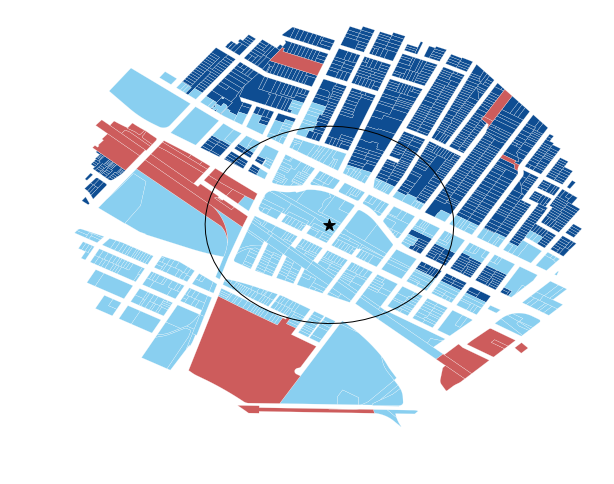

In [32]:
fruit_pz['land_use']='Other'

fruit_pz.loc[((fruit_pz['zone_base'] == 'Single-Family Residential') | 
              (fruit_pz['zone_base'] == 'Multi-Family Residential')), 'land_use'] = 'Residential'
fruit_pz.loc[((fruit_pz['zone_base'] == 'Commercial') | 
              (fruit_pz['zone_base'] == 'Mix') |
              (fruit_pz['zone_base'] == 'TOD')), 'land_use'] = 'Comercial/Mixed Use'

f, ax = plt.subplots(1, figsize=(10, 10))
ax = fruit_pz[fruit_pz['land_use'] == 'Residential'].plot(ax = ax, color='#0E4D92', edgecolor='white', linewidth=.2)
ax = fruit_pz[fruit_pz['land_use'] == 'Comercial/Mixed Use'].plot(ax = ax, color='#89CFF0', edgecolor='white', linewidth=.2)
ax = fruit_pz[fruit_pz['land_use'] == 'Other'].plot(ax = ax, color='#CD5C5C', edgecolor='white', linewidth=.2)
#ax = fruit_foots.plot(ax = ax, color='black', alpha=.5, edgecolor='black', linewidth=.2)
ax = fruit_station.plot(ax=ax, marker='*', color='black', markersize=150);
ax = station_quarter[station_quarter['name'] == 'Fruitvale BART'].plot(ax = ax, color='none', edgecolor='black', linewidth=1)

ax.set_axis_off()  
plt.savefig('Graphics/fruitvale_land_use.png', dpi=300)
plt.show()

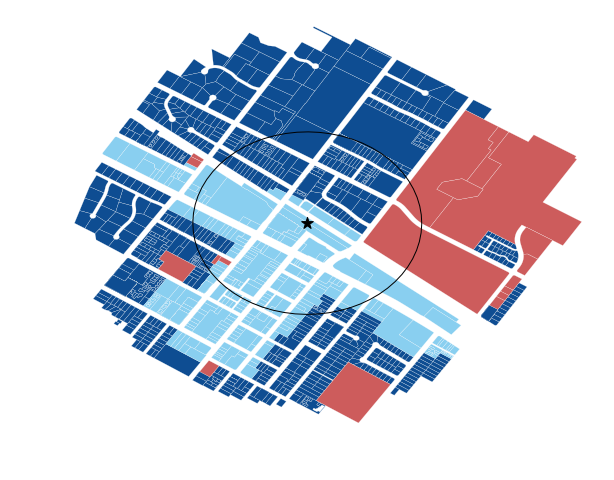

In [33]:
mp_pz['land_use']='Other'

mp_pz.loc[((mp_pz['zone_base'] == 'Single-Family Residential') | 
              (mp_pz['zone_base'] == 'Multi-Family Residential')), 'land_use'] = 'Residential'
mp_pz.loc[(mp_pz['zone_base'] == 'El Camino Real/Downtown Specific Plan'), 
          'land_use'] = 'Comercial/Mixed Use'

f, ax = plt.subplots(1, figsize=(10, 10))
ax = mp_pz[mp_pz['land_use'] == 'Residential'].plot(ax = ax, color='#0E4D92', edgecolor='white', linewidth=.2)
ax = mp_pz[mp_pz['land_use'] == 'Comercial/Mixed Use'].plot(ax = ax, color='#89CFF0', edgecolor='white', linewidth=.2)
ax = mp_pz[mp_pz['land_use'] == 'Other'].plot(ax = ax, color='#CD5C5C', edgecolor='white', linewidth=.2)
#ax = mp_foots.plot(ax = ax, color='black', alpha=.5, edgecolor='black', linewidth=.2)
ax = mp_station.plot(ax=ax, marker='*', color='black', markersize=150);
ax = station_quarter[station_quarter['name'] == 'Menlo Park Caltrain'].plot(ax = ax, color='none', edgecolor='black', linewidth=1)

ax.set_axis_off()  
plt.savefig('Graphics/menlopark_land_use', dpi=300)
plt.show()

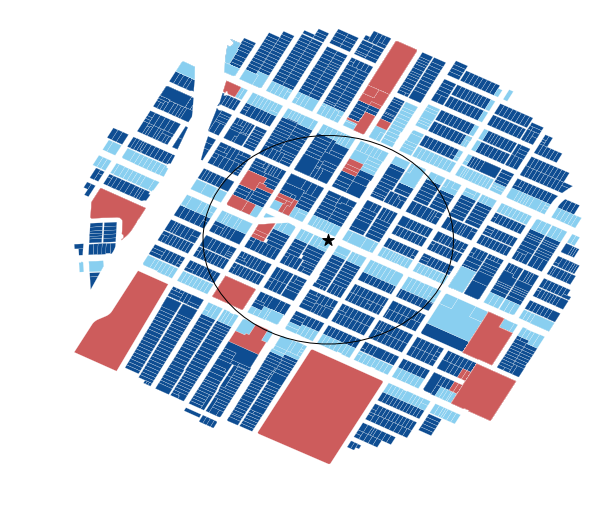

In [34]:
soto_pz['land_use']='Other'

soto_pz.loc[(soto_pz['zone_base'] == 'Commercial'), 'land_use'] = 'Comercial/Mixed Use'
soto_pz.loc[((soto_pz['zone_base'] == 'One-Family Residential') | 
              (soto_pz['zone_base'] == 'Multi-Family Residential') |
              (soto_pz['zone_base'] == 'Residential Estate')), 'land_use'] = 'Residential'

f, ax = plt.subplots(1, figsize=(10, 10))
ax = soto_pz[soto_pz['land_use'] == 'Residential'].plot(ax = ax, color='#0E4D92', edgecolor='white', linewidth=.2)
ax = soto_pz[soto_pz['land_use'] == 'Comercial/Mixed Use'].plot(ax = ax, color='#89CFF0', edgecolor='white', linewidth=.2)
ax = soto_pz[soto_pz['land_use'] == 'Other'].plot(ax = ax, color='#CD5C5C', edgecolor='white', linewidth=.2)
#ax = soto_foots.plot(ax = ax, color='black', alpha=.5, edgecolor='black', linewidth=.2)
ax = soto_station.plot(ax=ax, marker='*', color='black', markersize=150);
ax = station_quarter[station_quarter['name'] == 'Soto Station'].plot(ax = ax, color='none', edgecolor='black', linewidth=1)

ax.set_axis_off()  
plt.savefig('Graphics/boyleheights_land_use.png', dpi=300)
plt.show()

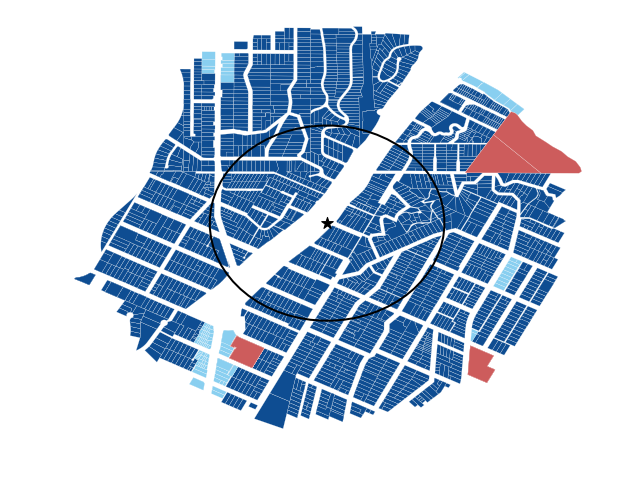

In [11]:
sl_pz['land_use']='Other'

sl_pz.loc[(sl_pz['zone_base'] == 'Commercial'), 'land_use'] = 'Comercial/Mixed Use'
sl_pz.loc[((sl_pz['zone_base'] == 'One-Family Residential') | 
              (sl_pz['zone_base'] == 'Multi-Family Residential') |
              (sl_pz['zone_base'] == 'Residential Estate')), 'land_use'] = 'Residential'

f, ax = plt.subplots(1, figsize=(10, 10))
ax = sl_pz[sl_pz['land_use'] == 'Residential'].plot(ax = ax, color='#0E4D92', edgecolor='white', linewidth=.2)
ax = sl_pz[sl_pz['land_use'] == 'Comercial/Mixed Use'].plot(ax = ax, color='#89CFF0', edgecolor='white', linewidth=.2)
ax = sl_pz[sl_pz['land_use'] == 'Other'].plot(ax = ax, color='#CD5C5C', edgecolor='white', linewidth=.2)
#ax = sl_foots.plot(ax = ax, color='black', alpha=.7, edgecolor='black', linewidth=.2)
ax = sl_station.plot(ax=ax, marker='*', color='black', markersize=150);
ax = station_quarter[station_quarter['name'] == 'Allesandro / Oak Glen'].plot(ax = ax, color='none', edgecolor='black', linewidth=2)
#ax = station_half[station_half['name'] == 'Allesandro / Oak Glen'].plot(ax = ax, color='none', edgecolor='black', linewidth=2)

ax.set_axis_off()  
plt.savefig('Graphics/silverlake_land_use.png', dpi=300)
plt.show()